In [22]:
import hdphmm
import mdtraj as md

In [23]:
traj = '5ms_nojump.xtc'
gro = 'em.gro'
residue = 'MET'
difference = True  # take first order difference of solute trajectories
observation_model='AR'  # assume an autoregressive model
order = 1  # autoregressive order
max_states = 20
traj_no = 2
radial = True  # replace xy coordinates with radial distance from pore centers
first_frame = 7000  # frame after which simulation is equilibrated

# You can define a dictionary with some spline paramters
spline_params = {'npts_spline': 10, 'save': True, 'savename': 'spline_hdphmm.pl'}

com = 'comr.pl'  # center of mass trajectories. If it exists, we can skip loading the MD trajectory and just load this

if com is not None:
    
    data = com
    load_com = True

else:
    
    data = traj
    load_com = False

ihmm = hdphmm.InfiniteHMM(data, radial=radial, traj_no=traj_no, gro=gro, load_com=load_com, res=residue, 
                          difference=True, observation_model=observation_model, order=order, 
                          max_states=max_states, first_frame=first_frame, spline_params=spline_params)


Loaded center-of-mass coordinates
Took first order difference of center of mass trajectories
Fitting 1 2 dimensional trajectories assuming an autoregressive order of 1


(4806, 1, 2)


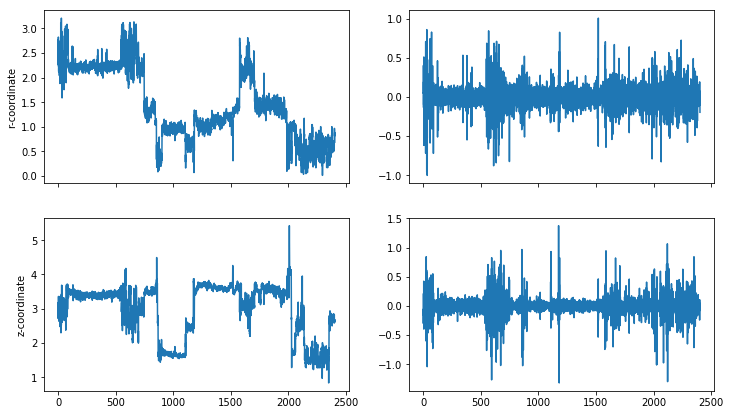

In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

print(ihmm.trajectories.shape)

nT = ihmm.trajectories.shape[0]
time = np.linspace(0, nT*ihmm.dt / 1000, nT)
ylabels = ['r-coordinate', 'z-coordinate']

for i in range(2):
    traj = ihmm.com[2:, 0, i]
    ax[i, 0].plot(time, traj)
    ax[i, 1].plot(time, ihmm.trajectories[:, 0, i])
    ax[i, 0].set_ylabel(ylabels[i])

#plt.xlabel('Time ($\mu$s)')
plt.show()

In [77]:
niter = 2000
ihmm.inference(niter)

100%|██████████| 2000/2000 [09:28<00:00,  3.70it/s]


Found 3 unique states

Estimated Transition Matrix:

[[0.9674 0.0249 0.0078]
 [0.0911 0.8259 0.083 ]
 [0.0025 0.22   0.7775]]


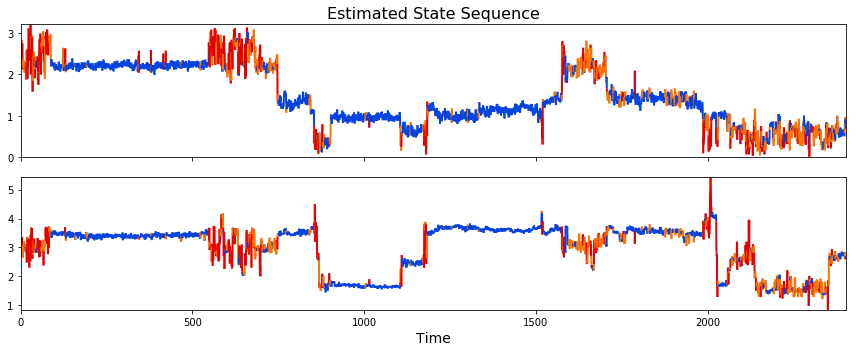

In [78]:
ihmm.summarize_results()

Let's look at the convergence of the parameters

[[ 0.0056 -0.0007]
 [-0.0007  0.0035]]
[[-0.3147 -0.0232]
 [-0.0097 -0.2992]]


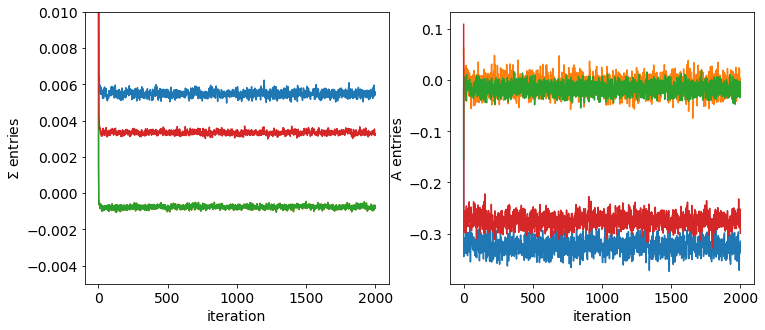

In [88]:
# Autoregressive Parameters

#print(ihmm.z[0, 275:1000])

estimated_states = ihmm.z[0, :]  # estimated state sequence

plot_state = 0
found_states = list(np.unique(estimated_states))  # all of the states that were identified

sigma = np.zeros([niter + 1, 2, 2])
A = np.zeros([niter + 1, 2, 2])

for a in range(niter + 1):
    A[a, ...] = ihmm.convergence['A'][a][..., found_states[plot_state], 0]
    sigma[a, ...] = np.linalg.inv(ihmm.convergence['invSigma'][a][..., found_states[plot_state], 0])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(4):
    ax[0].plot(sigma[:, i // 2, i % 2])
    ax[1].plot(A[:, i // 2, i % 2])

print(sigma.mean(axis=0))
print(A[-1, ...])
ax[0].set_ylim(-0.005, 0.01)
ax[0].tick_params(labelsize=14)
ax[0].set_xlabel('iteration', fontsize=14)
ax[0].set_ylabel(r'$\Sigma$ entries', fontsize=14)

ax[1].tick_params(labelsize=14)
ax[1].set_xlabel('iteration', fontsize=14)
ax[1].set_ylabel('A entries', fontsize=14)

plt.show()

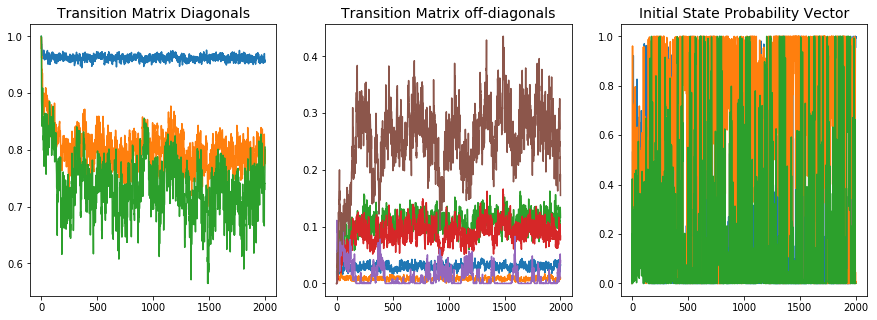

In [84]:
# Transition matrix and initial distribution

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

T = np.zeros([niter + 1, len(found_states), len(found_states)])
pi_init = np.zeros([niter + 1, len(found_states)])

block = tuple(np.meshgrid(found_states, found_states))

for i in range(niter + 1):
    T[i, ...] = ihmm.convergence['T'][i][block].T
    pi_init[i, :] = ihmm.convergence['pi_init'][i][found_states]
    for j in range(len(found_states)):
        T[i, j, :] /= T[i, j, :].sum()

for i in range(len(found_states)):
    for j in range(len(found_states)):
        if i == j:
            ax[0].plot(T[:, i, j])
        else: 
            ax[1].plot(T[:, i, j])
    ax[2].plot(pi_init[:, i])

ax[0].set_title('Transition Matrix Diagonals', fontsize=14)
ax[1].set_title('Transition Matrix off-diagonals', fontsize=14)
ax[2].set_title('Initial State Probability Vector', fontsize=14)
    
plt.show()

The HDPHMM algorithm has functionality to detect the equilibration of these parameters. It will then return a distribution of parameters in a dictionary.

In [81]:
ihmm._get_params()

Found 3 unique states

Estimated Transition Matrix:

[[0.9674 0.0249 0.0078]
 [0.0911 0.8259 0.083 ]
 [0.0025 0.22   0.7775]]

Autoregressive parameters equilibrated after 1202 iterations


In [83]:
print(ihmm.converged_params['A'].shape)

(1901, 2, 2, 3)
